# Project - Fourth Requirement

### Include packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy
from itertools import product

### Environment

Let's define some types of non-stationary environments...

In [2]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

With sinusoidally-varying "true value".

In [3]:
class PricingEnvironmentMultiProductSinusoidalMean:
    def __init__(self, cost_vector, initial_mean_valuations, std_valuations, buyers_per_round, total_rounds, amplitudes, periods):
        # Initialize the environment
        self.cost_vector = np.array(cost_vector)  
        self.initial_mean_valuations = np.array(initial_mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round  
        self.total_rounds = total_rounds
        self.current_round = 0

        # Each product has its own amplitude and period for the sinusoidal valuation
        self.amplitudes = np.array(amplitudes)
        self.periods = np.array(periods)

    def round(self, p_t_vector):
        # Define the valuations for each product at the current round
        mean_valuations = self.initial_mean_valuations + self.amplitudes * np.sin(2 * np.pi * self.current_round / self.periods)

        # Sample sales
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy) 
        
        # Compute the reward and go on
        reward = ( np.array(p_t_vector) - self.cost_vector ) * num_sales
        self.current_round += 1
        return num_sales, reward

### Now define the setting...

In [4]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 3                # Independent trials

# --- Pricing Grid and Product Info ---

cost_vector = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

min_p = 0.0
max_p = int(np.max(initial_values) * 2)

K = 10
P = np.linspace(min_p, max_p, K)                    # Shared price grid for all products

assert np.all(cost_vector < initial_values), "Each cost must be less than its initial valuation"

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

zoom_end = 2 * max(periods)     # Show only up to 2x the max period in main plots
zoom_end_mini = 200             # Show only up to 200 rounds in mini plots
zoom_end_5 = 5000               # Start zooming 5k rounds
s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

### Design our agent

In [5]:
class EXP3P:
    def __init__(self, num_actions, gamma, eta, max_reward_scale):
        self.num_actions = num_actions
        self.gamma = gamma
        self.eta = eta
        self.weights = np.ones(num_actions)
        self.probabilities = np.zeros(num_actions)
        # Safe upper bound on absolute reward
        self.max_reward_scale = max_reward_scale

    def choose_action(self):
        sum_weights = np.sum(self.weights)
        self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + (self.gamma / self.num_actions)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.num_actions, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Normalize reward and compute loss
        normalized_reward = observed_reward / self.max_reward_scale
        loss_t = (1 - normalized_reward) / 2
        estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)

        # Normalize weights if needed
        w_sum = np.sum(self.weights)
        if w_sum < 1e-100 or w_sum > 1e100:
            self.weights /= np.max(self.weights)

class PrimalDualMultiProductPricingAgent:
    def __init__(self, prices, B, T, cost_vector, buyers_per_round, initial_lambda=0, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None):
        self.prices = prices
        self.K = len(prices) # Number of price options
        self.N = len(cost_vector) # Number of products

        self.B = B # Total budget
        self.T = T # Total time horizon
        self.cost_vector = np.array(cost_vector)
        self.buyers_per_round = buyers_per_round
        self.rho = B / T if T > 0 else 1e-8 # Initial target average sales per round
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        self.current_round = 0
        self.remaining_budget = B

        # Determine a safe upper bound for reward scaling for EXP3P
        max_possible_sales_per_product = buyers_per_round
        max_possible_profit_per_product_per_round = (np.max(prices) - np.min(cost_vector)) * max_possible_sales_per_product
        self.max_reward_scale = max_possible_profit_per_product_per_round + (np.max(self.prices) * 2) * self.buyers_per_round
        if self.max_reward_scale == 0:
            self.max_reward_scale = 1.0

        # Init leargning rate in case not provided
        if exp3p_eta is None:
            exp3p_eta = np.sqrt(2 * np.log(self.K) / (self.K * self.T))
        # Initialize the products' regret minimizers
        self.product_regret_minimizers = [ EXP3P(num_actions=self.K, gamma=exp3p_gamma, eta=exp3p_eta, max_reward_scale=self.max_reward_scale) for _ in range(self.N) ]

        self.history_chosen_price_indices = []
        self.history_lambda = [self.lambda_t]
        self.history_total_sales = []
        self.history_total_rewards = []
        self.history_rho_target = []

    def choose_prices(self):
        chosen_prices = []
        chosen_indices = []
        for i in range(self.N):
            idx = self.product_regret_minimizers[i].choose_action()
            chosen_prices.append(self.prices[idx])
            chosen_indices.append(idx)

        self.history_chosen_price_indices.append(chosen_indices)
        return np.array(chosen_prices), chosen_indices

    def update(self, chosen_indices, sales_vector, rewards_vector):
        total_sales = np.sum(sales_vector)
        self.history_total_sales.append(total_sales)
        self.history_total_rewards.append(np.sum(rewards_vector))
        self.history_rho_target.append(self.rho) # Store current rho for plotting

        # Update the regret minimizers for each product
        for i in range(self.N):
            price = self.prices[chosen_indices[i]]
            cost = self.cost_vector[i]
            num_sales = sales_vector[i]

            rho_per_product = self.rho / self.N
            effective_reward = (price - cost) * num_sales - self.lambda_t * (num_sales - rho_per_product)
            self.product_regret_minimizers[i].update(chosen_indices[i], effective_reward)

        # Update budget
        self.remaining_budget -= total_sales
        self.current_round += 1
        rounds_left = self.T - self.current_round
        self.rho = self.remaining_budget / rounds_left if rounds_left > 0 else 0

        # Lambda update
        diff = total_sales - self.rho
        lambda_update = self.eta_lambda * diff
        self.lambda_t += lambda_update
        self.lambda_t = np.clip(self.lambda_t, 0, np.max(self.prices) * 2)
        self.history_lambda.append(self.lambda_t)

        if self.remaining_budget < 0:
            print(f"Budget exhausted at round {self.current_round}. Total sales: {np.sum(self.history_total_sales)}")
            return False
        return True

### First experiment

Run the simulation

In [6]:
# --- Simulation ---
all_rewards = []        # Shape: (n_trials, T)
all_lambdas = []        # Shape: (n_trials, <=T+1)
all_rho_targets = []    # Shape: (n_trials, <=T)
all_sold_pieces = []    # Shape: (n_trials, <=T)

for seed in range(n_trials):
    np.random.seed(seed)

    # --- Set up environment ---
    env = PricingEnvironmentMultiProductSinusoidalMean(cost_vector=cost_vector, initial_mean_valuations=initial_values, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T, amplitudes=amplitudes, periods=periods)

    # --- Initialize agent ---
    agent = PrimalDualMultiProductPricingAgent(prices=P, B=B, T=T, cost_vector=cost_vector, buyers_per_round=buyers_per_round, initial_lambda=0, learning_rate_lambda=0.001, exp3p_gamma=0.1, exp3p_eta=None)

    rewards_trial = np.zeros(T)
    rho_values_trial = [] # This will be replaced by agent.history_rho_target
    sold_pieces_values_trial = []

    for t in range(T):
        price_vec, idx_vec = agent.choose_prices()
        sales_vec, reward_vec = env.round(price_vec)
        cont = agent.update(idx_vec, sales_vec, reward_vec)

        rewards_trial[t] = np.sum(reward_vec)
        if not cont:
            rewards_trial[t+1:] = 0
            break
        # No longer need to append to rho_values_trial and sold_pieces_values_trial here
        # as they are now stored directly in agent.history_rho_target and agent.history_total_sales
        # (The history_total_sales was already being appended in agent.update)

    all_rewards.append(np.cumsum(rewards_trial))
    all_lambdas.append(agent.history_lambda)
    all_rho_targets.append(agent.history_rho_target)
    all_sold_pieces.append(agent.history_total_sales)

# --- Analysis and Plotting ---

# Cumulative Utility
all_rewards = np.array(all_rewards)  # shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Dual variable lambda
all_lambdas_padded = [l + [np.nan] * (T + 1 - len(l)) for l in all_lambdas]
all_lambdas = np.array(all_lambdas_padded)

valid_mask_lambda = ~np.isnan(all_lambdas).all(axis=0)
mean_lambda = np.full(T + 1, np.nan)
std_lambda = np.full(T + 1, np.nan)
mean_lambda[valid_mask_lambda] = np.nanmean(all_lambdas[:, valid_mask_lambda], axis=0)
std_lambda[valid_mask_lambda] = np.nanstd(all_lambdas[:, valid_mask_lambda], axis=0)

# Sold Pieces and Target Rho
# Pad sold_pieces and rho_targets since trials might end early
all_sold_pieces_padded = [s + [np.nan] * (T - len(s)) for s in all_sold_pieces] # Use T as max length
all_sold_pieces = np.array(all_sold_pieces_padded)

# No longer need max_len_rho_targets and all_rho_targets_padded
all_rho_targets_padded = [r + [np.nan] * (T - len(r)) for r in all_rho_targets] # Use T as max length
all_rho_targets = np.array(all_rho_targets_padded)

mean_sold_pieces = np.nanmean(all_sold_pieces, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces, axis=0)

mean_rho_targets = np.nanmean(all_rho_targets, axis=0)
std_rho_targets = np.nanstd(all_rho_targets, axis=0)

### Compute regret

Compute

In [ ]:
# --- Clairvoyant with Static Pricing and Budget Constraint---

clairvoyant_static_rewards = []
static_summary_all_trials = []

# Precompute all possible price combinations
all_combinations = list(product(range(K), repeat=N))
price_matrix = np.array([P[list(indices)] for indices in all_combinations])  # shape: (num_combinations, N)

for seed in range(n_trials):
    print(f"\n>>> Running static clairvoyant trial {seed + 1}/{n_trials}...")
    np.random.seed(seed)
    summary_this_trial = []

    # === Precompute all buyer valuations (shape: [T, buyers, N]) ===
    sin_component = amplitudes * np.sin(2 * np.pi * np.arange(T)[:, None] / periods)
    mean_valuations = initial_values + sin_component  # shape: [T, N]
    noise = np.random.normal(0, std_valuations, size=(T, buyers_per_round, N))
    valuations = mean_valuations[:, None, :] + noise  # shape: [T, buyers, N]

    # Initialize variables for tracking the best results
    best_total_reward = -np.inf
    best_combination = None
    best_cumulative_reward = np.zeros(T)
    best_budget_used = 0
    best_rounds_played = 0

    # Iterate over all price combinations
    for idx, p_fixed in enumerate(price_matrix):
        remaining_budget = B
        cumulative_reward = np.zeros(T)
        total_sales_so_far = 0

        # Simulate the rounds with the fixed price combination
        for t in range(T):
            buyer_vals = valuations[t]  # shape: [buyers, N]
            bought = (buyer_vals >= p_fixed).astype(int)  # shape: [buyers, N]
            sales = bought.sum(axis=0)
            rewards = bought * (p_fixed - cost_vector)  # shape: [buyers, N]
            total_reward = rewards.sum()

            if remaining_budget < sales.sum():
                break

            remaining_budget -= sales.sum()
            cumulative_reward[t] = cumulative_reward[t - 1] + total_reward if t > 0 else total_reward

        rounds_played = t + 1
        final_reward = cumulative_reward[t] if t < T else cumulative_reward[-1]
        budget_used = B - remaining_budget

        summary_this_trial.append({
            "prices": p_fixed,
            "reward": final_reward,
            "budget_used": budget_used,
            "rounds_played": rounds_played
        })

        if final_reward > best_total_reward:
            best_total_reward = final_reward
            best_combination = p_fixed
            best_cumulative_reward = cumulative_reward.copy()
            best_budget_used = budget_used
            best_rounds_played = rounds_played

    clairvoyant_static_rewards.append(best_cumulative_reward)
    static_summary_all_trials.append({
        "trial": seed,
        "best_prices": best_combination,
        "reward": best_total_reward,
        "budget_used": best_budget_used,
        "rounds_played": best_rounds_played,
        "all_combinations": summary_this_trial
    })

# Convert to NumPy array for statistics: shape = (n_trials, T)
clairvoyant_static_rewards = np.array(clairvoyant_static_rewards)

# Compute mean and std across trials (for plotting)
mean_clairvoyant_static = np.mean(clairvoyant_static_rewards, axis=0)
std_clairvoyant_static = np.std(clairvoyant_static_rewards, axis=0)

# --- Optional: Print overall summary ---
best_trial_index = np.argmax([trial["reward"] for trial in static_summary_all_trials])
best_trial = static_summary_all_trials[best_trial_index]

print(f"\n>>> Best static clairvoyant reward across {n_trials} trials after {T} rounds:")
print(f"    Total Reward: {best_trial['reward']:.2f}")
print(f"    Prices: {np.array2string(best_trial['best_prices'], precision=2)}")
print(f"    Budget Used: {best_trial['budget_used']}, Rounds Played: {best_trial['rounds_played']}")

# Optional: quick view of mean final reward
print(f">>> Mean Final Reward for Static Clairvoyant: {mean_clairvoyant_static[-1]:.2f} ± {std_clairvoyant_static[-1]:.2f}\n")

# --- Clairvoyant with Dynamic Pricing and No Budget---

clairvoyant_dynamic_rewards = []

# Precompute all price combos once
all_price_indices = np.array(list(product(range(K), repeat=N)))
all_prices = P[all_price_indices]  # (num_combinations, N)

# Precompute sinusoidal means for all rounds
sin_vals = np.sin(2 * np.pi * np.arange(T)[:, None] / env.periods)  # (T, N)
mean_vals_all = env.initial_mean_valuations + env.amplitudes * sin_vals  # (T, N)

for t in range(T):
    mean_vals = mean_vals_all[t].reshape(1, -1)  # (1, N)
    std_vals = std_valuations.reshape(1, -1)    # (1, N)

    prob_buy = 1 - norm.cdf(all_prices, loc=mean_vals, scale=std_vals)  # (num_combinations, N)
    expected_sales = prob_buy * buyers_per_round
    expected_reward = (all_prices - cost_vector) * expected_sales
    total_expected_reward = np.sum(expected_reward, axis=1)

    best_index = np.argmax(total_expected_reward)
    best_prices = all_prices[best_index]

    _, actual_rewards = env.round(best_prices)
    cumulative_reward[t] = cumulative_reward[t-1] + np.sum(actual_rewards) if t > 0 else np.sum(actual_rewards)

    clairvoyant_dynamic_rewards.append(cumulative_reward)

clairvoyant_dynamic_rewards = np.array(clairvoyant_dynamic_rewards)
mean_clairvoyant_dynamic = np.mean(clairvoyant_dynamic_rewards, axis=0)

print(f">>> Mean Final Reward for Dynamic Clairvoyant: {mean_clairvoyant_dynamic[-1]:.2f}")


>>> Running static clairvoyant trial 1/3...


Plot

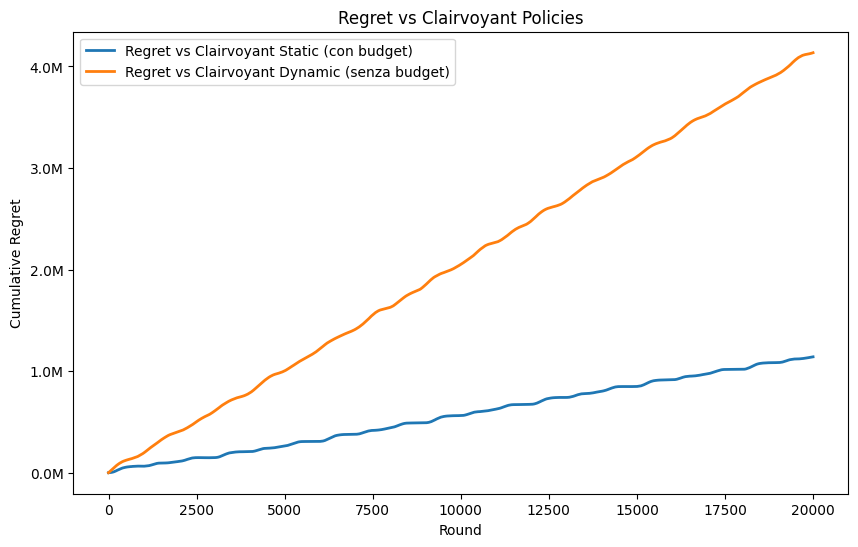

In [ ]:
plt.figure(figsize=(10,6))
mean_regret_static = mean_clairvoyant_static - mean_cum_util
mean_regret_dynamic = mean_clairvoyant_dynamic - mean_cum_util

plt.plot(mean_regret_static, label='Regret vs Clairvoyant Static (con budget)', linewidth=2)
plt.plot(mean_regret_dynamic, label='Regret vs Clairvoyant Dynamic (senza budget)', linewidth=2)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Regret vs Clairvoyant')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
_ = plt.legend()